# Project 3 - Ensemble Models & Timeseries Forecasing
Γεώργιος Δάλλας ΑΕΜ: 217 <br>

The goal of this project is the prediction of the US Dollar price <br>


In [543]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import StackingRegressor

In [544]:
ticker_symbol = "DX-Y.NYB"
ticker = yf.Ticker(ticker_symbol)
df = ticker.history(period="5y").reset_index(drop=False)
df

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2020-11-05 00:00:00-05:00,93.339996,93.550003,92.489998,92.529999,0,0.0,0.0
1,2020-11-06 00:00:00-05:00,92.570000,92.820000,92.180000,92.230003,0,0.0,0.0
2,2020-11-09 00:00:00-05:00,92.239998,92.959999,92.129997,92.730003,0,0.0,0.0
3,2020-11-10 00:00:00-05:00,92.760002,92.970001,92.599998,92.750000,0,0.0,0.0
4,2020-11-11 00:00:00-05:00,92.699997,93.209999,92.610001,93.040001,0,0.0,0.0
...,...,...,...,...,...,...,...,...
1252,2025-10-29 00:00:00-04:00,98.739998,99.360001,98.620003,99.220001,0,0.0,0.0
1253,2025-10-30 00:00:00-04:00,99.139999,99.720001,98.919998,99.529999,0,0.0,0.0
1254,2025-10-31 00:00:00-04:00,99.489998,99.839996,99.419998,99.800003,0,0.0,0.0
1255,2025-11-03 00:00:00-05:00,99.750000,99.989998,99.709999,99.870003,0,0.0,0.0


# 1.
On this step a line plot with open, high, low and close values of the created dataframe is created.

In [545]:
import plotly.express as px

fig = px.line(df, x='Date', y=['Open','High','Low','Close'], title='US Dollar value in the last 5 years',height=700)
fig.show()

# 2.
The time series shown above (line plot) are non stationary since they constantly shift away from the average value.

# 3. 
When training a model on non stationary time series like the one shown above, the the model can only predict well on values around the average. So if the data shifts away since its non stationary, the model will not be able to predict well. In the plot shown above, no regression models could predict the drastic fall shown around the 27th of September of 2022. There are ways to move from non stationary time series like the one used to stationary by differencing, but there is no way to predict changes from outside factors like the one mentioned.

# 4. 
The trend of USD seemed to slightly decrease between June and July of 2025. There is no exact reasons to pinpoint for this decrease but rather many reasons contributed. One of them was the instability caused by US Tariff threats, creating uncertainty in the global market.

# 5.
By having open, high, low and close data for many continuous days, it is possible to predict the close value of the next day. The outcome of course most of the time wont be extremely accurate, since there are many more variables contributing to real world market prices, but a good enough approximation function can be made using open, high, low as X variables and close variable as Y (building a regression model). By having data only for one day, it is impossible to predict the close value of the next day, since its impossible to know how these variables change in time (which is exactly the field of interest).

# 6.
Taking random samples for train and test data, will not make any sense. When predicting price, time is really important. The scale of the data can change if 2 samples are far appart in time and predictors tend to perform well just for the near future. If samples are far appart and random, the market can appear chaotic.

# 7.
On this step, train (all data before 2024) and test (all data of 2024) dataframes are created.

In [546]:
masktrain = df['Date'] < '2024-01-01'
masktest = (df['Date'] >= '2024-01-01') & (df['Date'] < '2025-01-01')

train = df[masktrain]
test = df[masktest]

train = train.drop(['Date'], axis=1)
test = test.drop(['Date'], axis=1)



# 8.
On this step the timeframe creator function is created. It takes a dataframe and an integer N for input and outputs 2 numpy arrays. X array contains samples * N * variables and y array the close value variable of the day after each frame.

In [547]:
def timeframe_maker(dataframe, N):
    x, y = [], []
    data = dataframe.to_numpy()
    for i in range(dataframe.shape[0]-N):
        x.append(data[i:i+N])
        y.append(data[i+N][3]) # close is the 4th column of both train and test dataframes   
    return np.array(x), np.array(y)




# 9.
If we want to predict the accuracy of the next day, the N size of the timeframe must be small (a few days). That's beacause when looking at the market between a few days, the values change drastically relatively to the market in a month. So when we need to predict the USD Value in a month we would need a much bigger N size. To put it more simply, most of the time, the trend of a market over a month is much smoother than the trend observed in a day. 

# 10.
The N value selected is 5. x_train ,y_train and x_test, y_test are created using timeframe_maker and x sets are reshaped appropriately to fit in ML models from sklearn.

In [548]:
N =5
x_train, y_train = timeframe_maker(train, N)
x_test, y_test = timeframe_maker(test, N)



x_train =x_train[:, :, :4]
x_test = x_test[:, :, :4]

x_train = x_train.reshape(x_train.shape[0], -1)  # (samples, 20)
x_test = x_test.reshape(x_test.shape[0], -1)
print("Sizes of x and y train after removing extra columns and reshaping:")
print(x_train.shape, y_train.shape)
print("Sizes of x and y test after removing extra columns and reshaping:")
print(x_test.shape, y_test.shape)
print("1st sample of x_train")
print(x_train[0])

Sizes of x and y train after removing extra columns and reshaping:
(787, 20) (787,)
Sizes of x and y test after removing extra columns and reshaping:
(247, 20) (247,)
1st sample of x_train
[93.33999634 93.55000305 92.48999786 92.52999878 92.56999969 92.81999969
 92.18000031 92.23000336 92.23999786 92.95999908 92.12999725 92.73000336
 92.76000214 92.97000122 92.59999847 92.75       92.69999695 93.20999908
 92.61000061 93.04000092]


# 11.
Here, for the the following models MAE is calculated on the created dataset: <br>
Linear Regression: This model tries to fit a line by adjusting a weight of each variable given, with the goal of minimizing the residual sum of squares between the outputs sum(predicted - real)^2. It is considered to be a really simple model, but also a powerful one since weight values directly correspond to a feuture's importance. <br>
Random Forest: Random forests is an ensemble technique that creates subsets of the dataset by removing some samples and randomly copying some others, picks random feuters for each set and trains decision trees on each one of them. This way each tree "focuses" on different rules and the final results is taken by voting. <br>
Bagging Regressor:  Bagging is the technique that random forests use, called bootstrap aggregating. As said above, it creates subsets by removing samples and taking duplicates of other samples. The default estimator that is used here for the Bagging Regressor is a Decision Tree. So the only difference is that bootstrapping features is disabled here (although this can change just by having  bootstrap_features=True). <br>
XGBoost Regressor: XGBoost uses gradient boosting. It basically assigns a weight on each sample based on how wrong a previous prediction was. Gradient boosting tries to optimize a loss function that forces the next models to learn to perform better on samples with big weight.  XGBoost also does regularization, automatically handles missing values and many other things making it a really strong boosting model. <br>
Stacking Regressor: Stacking is taking models and training a new new meta-learner to predict the correct output based on the prediction of the other models rather than trying to predict based on input data. Here, for example, a linear regression model and a decision tree will create predictions, and a final estimator, in this case a RidgeCV regressor (default), will try to learn predicting the correct output by getting the predictions of the 2 other models as input. <br>
It is important to note that there was no experimenting with hyperparameters so results dont represent the power of each model in this dataset.

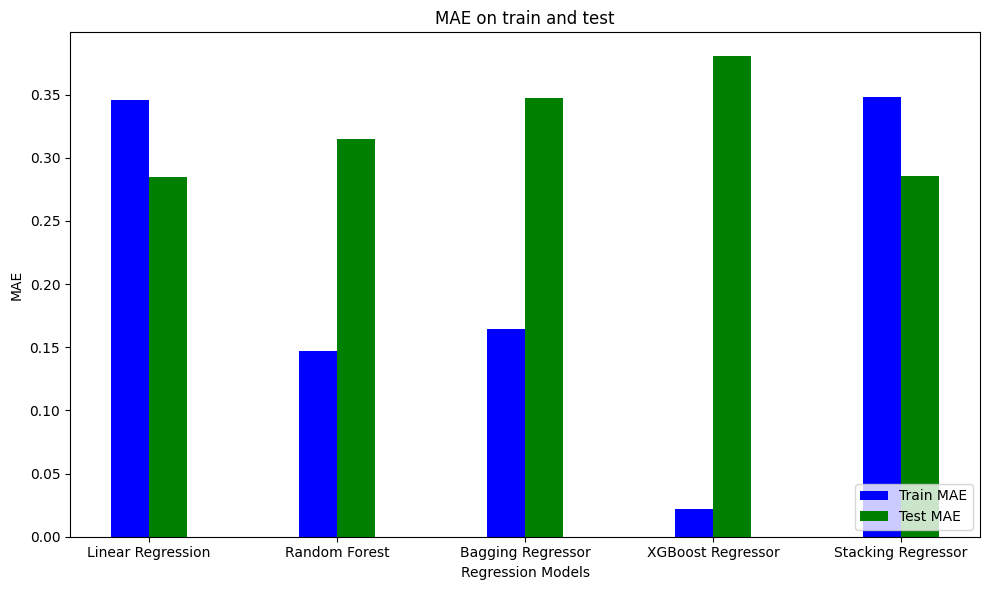

In [549]:
decTree = DecisionTreeRegressor()
model1 = LinearRegression()
model2 = RandomForestRegressor()
model3 = BaggingRegressor()
model4 = XGBRegressor()
estimators = [
    ('lr', model1),
    ('dtr', decTree),
]
model5 = StackingRegressor( #final is ridgecv
    estimators=estimators,
)


model_names = ['Linear Regression', 'Random Forest', 'Bagging Regressor', 'XGBoost Regressor', 'Stacking Regressor']
mae_list_train = []
mae_list_test = []



for model in [model1, model2, model3, model4, model5]:
    model.fit(x_train, y_train)

    y_pred_train = model.predict(x_train)
    mae = np.mean(np.abs(y_train - y_pred_train))
    mae_list_train.append(mae)



    y_pred_test = model.predict(x_test)
    mae = np.mean(np.abs(y_test - y_pred_test))
    mae_list_test.append(mae)




x = np.arange(len(model_names))

plt.figure(figsize=(10,6))
plt.bar(x - 0.1, mae_list_train, 0.2, label='Train MAE', color='blue')
plt.bar(x + 0.1, mae_list_test, 0.2, label='Test MAE', color='green')

plt.xlabel('Regression Models')
plt.ylabel('MAE')
plt.title('MAE on train and test')
plt.xticks(x, model_names)
plt.legend(loc='lower right')


plt.tight_layout()
plt.show()


# 12.
a) By exctrating the month and day for each sample as features we gain really important information, since in markets, patterns can be observed based on a month. Even days can contribute a bit on better predictions if for example for some reason in the market prices go up every end of a month. <br>
b) For Open,High,Low,Close and Volume, Log returns formula is applied. <br>
c)  By applying that formula, data gets normalized. The histograms show a much more normal distribution compared to histograms without the log returns formula applied. This basically makes the input more stationary, so more predictable. <br>
d) If rt+1 = 0.01, this means that close value changed by a log return of 1%. If Ct=0.95$, Ct+1 would be 0.95 * e^0.01 = 0.95954
e) Models from step 11 are trained again using the new dataframe. 

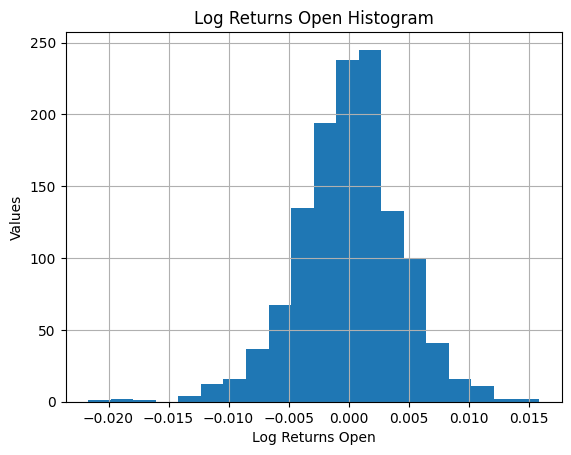

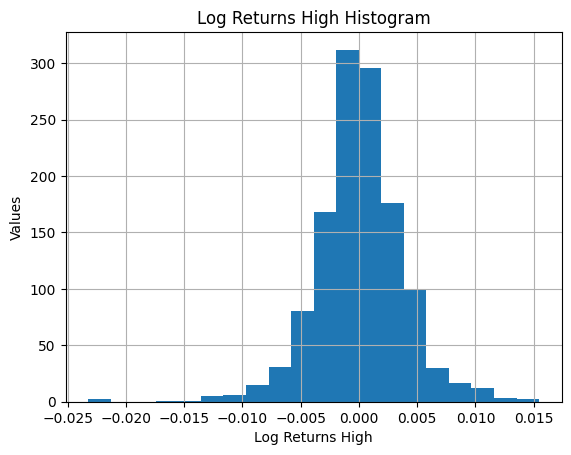

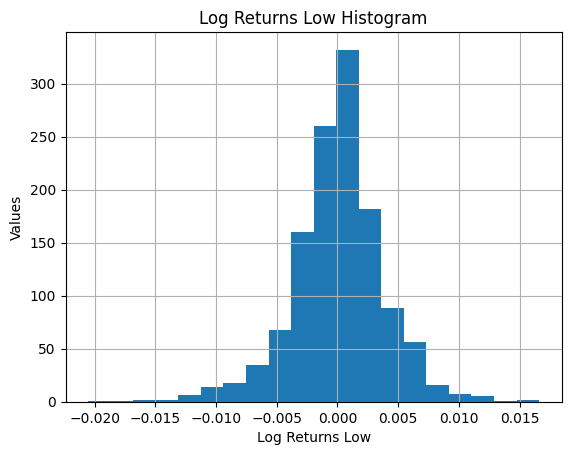

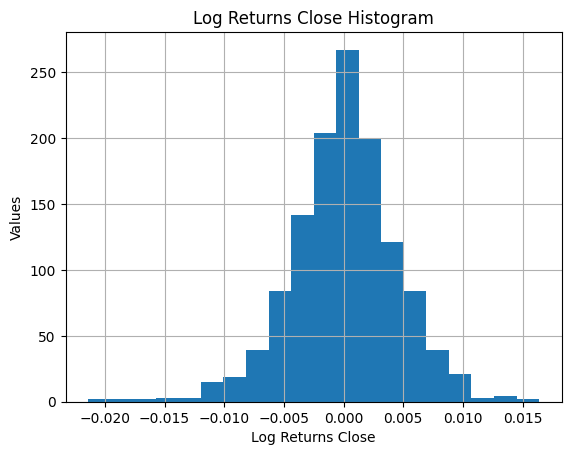

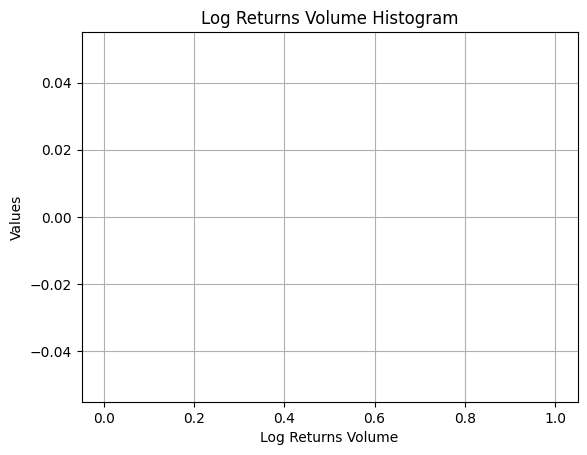

In [550]:
#a
df['Day'] = df['Date'].dt.day
df['Month'] = df['Date'].dt.month



#  used for 13th step
df_prices = df.copy()
df_prices = df_prices.drop(['Volume'], axis=1)
df_prices = df_prices.dropna().reset_index(drop=True)
mask_train = df_prices['Date'] < '2024-01-01'
mask_test = (df_prices['Date'] >= '2024-01-01') & (df_prices['Date'] < '2025-01-01')
train_price_df = df_prices[mask_train]
test_price_df = df_prices[mask_test]

_, y_train_price = timeframe_maker(train_price_df[['Open','High','Low','Close']], N)
_, y_test_price  = timeframe_maker(test_price_df[['Open','High','Low','Close']], N)






#b
df_log_returns = df.copy()
for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
    df_log_returns[col] = np.log(1 + df_log_returns[col].pct_change())



#c
df_log_returns['Open'].hist(bins=20)
plt.title('Log Returns Open Histogram')
plt.xlabel('Log Returns Open')
plt.ylabel('Values')
plt.show()
df_log_returns['High'].hist(bins=20)
plt.title('Log Returns High Histogram')
plt.xlabel('Log Returns High')
plt.ylabel('Values')
plt.show()
df_log_returns['Low'].hist(bins=20)
plt.title('Log Returns Low Histogram')
plt.xlabel('Log Returns Low')
plt.ylabel('Values')
plt.show()
df_log_returns['Close'].hist(bins=20)
plt.title('Log Returns Close Histogram')
plt.xlabel('Log Returns Close')
plt.ylabel('Values')
plt.show()
df_log_returns['Volume'].hist(bins=20)
plt.title('Log Returns Volume Histogram')
plt.xlabel('Log Returns Volume')
plt.ylabel('Values')
plt.show()

#e
#drop volume column
df_log_returns = df_log_returns.drop(['Volume'], axis=1)
#drop first row with NaN values
df_log_returns = df_log_returns.dropna().reset_index(drop=True)
masktrain = df_log_returns['Date'] < '2024-01-01'
masktest = (df_log_returns['Date'] >= '2024-01-01') & (df_log_returns['Date'] < '2025-01-01')

train = df_log_returns[masktrain]
test = df_log_returns[masktest]

train = train.drop(['Date'], axis=1)
test = test.drop(['Date'], axis=1)



N =5
x_train, y_train = timeframe_maker(train, N)
x_test, y_test = timeframe_maker(test, N)



x_train =x_train[:, :, :4]
x_test = x_test[:, :, :4]

x_train = x_train.reshape(x_train.shape[0], -1)  # (samples, 20)
x_test = x_test.reshape(x_test.shape[0], -1)

min_len_train = min(len(y_train_price), len(y_train))
y_train_price = y_train_price[:min_len_train]
y_train = y_train[:min_len_train]

min_len_test = min(len(y_test_price), len(y_test))
y_test_price = y_test_price[:min_len_test]
y_test = y_test[:min_len_test]


decTree = DecisionTreeRegressor()
model1 = LinearRegression()
model2 = RandomForestRegressor()
model3 = BaggingRegressor()
model4 = XGBRegressor()
estimators = [
    ('lr', model1),
    ('dtr', decTree),
]
model5 = StackingRegressor( #final is ridgecv
    estimators=estimators,
)


model_names = ['Linear Regression', 'Random Forest', 'Bagging Regressor', 'XGBoost Regressor', 'Stacking Regressor']
mae_list_train2 = []
mae_list_test2 = []







for model in [model1, model2, model3, model4, model5]:
    model.fit(x_train, y_train) 
    y_pred_train = model.predict(x_train)

    price_pred_train = y_train_price * np.exp(y_pred_train - y_train)
    mae = np.mean(np.abs(y_train_price - price_pred_train))
    mae_list_train2.append(mae)

    y_pred_test = model.predict(x_test)
    price_pred_test = y_test_price * np.exp(y_pred_test - y_test)
    mae = np.mean(np.abs(y_test_price - price_pred_test))
    mae_list_test2.append(mae)








# 13. 
On this step we compare the best performing models using log returns and just prices as inputs


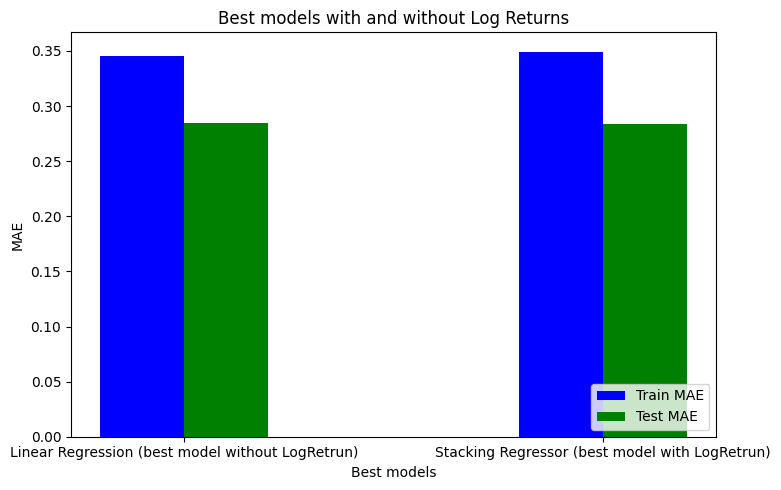

In [551]:
best_idx_test1 = np.argmin(mae_list_test)
best_idx_test2 = np.argmin(mae_list_test2)

bestModels = [model_names[best_idx_test1]+' (best model without LogRetrun)', model_names[best_idx_test2]+' (best model with LogRetrun)']

x = np.arange(len(bestModels))
mae_values_test = [mae_list_test[best_idx_test1], mae_list_test2[best_idx_test2]]
mae_values_train = [mae_list_train[best_idx_test1], mae_list_train2[best_idx_test2]]
plt.figure(figsize=(8,5))
plt.bar(x - 0.1, mae_values_train, 0.2, label='Train MAE', color='blue')
plt.bar(x + 0.1, mae_values_test, 0.2, label='Test MAE', color='green')
plt.xlabel('Best models')
plt.ylabel('MAE')
plt.title('Best models with and without Log Returns')
plt.xticks(x, bestModels)
plt.tight_layout()
plt.legend(loc='lower right')
plt.show()